In [1]:
import os
import math
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from visualization_tools.navigation_visualization_tools import (
    sample_random_pose, perturb_pose_off_walkable_pose,
    plot_floorplan, plot_points, plot_pose, draw_graph_on_floorplans, plot_navigation_path
)
from config import UNavConfig
from navigator.commander import commands_from_result
from navigator.multifloor import FacilityNavigator

[✓] YAML written to: /mnt/data/UNav-IO/temp/equirectangular.yaml.


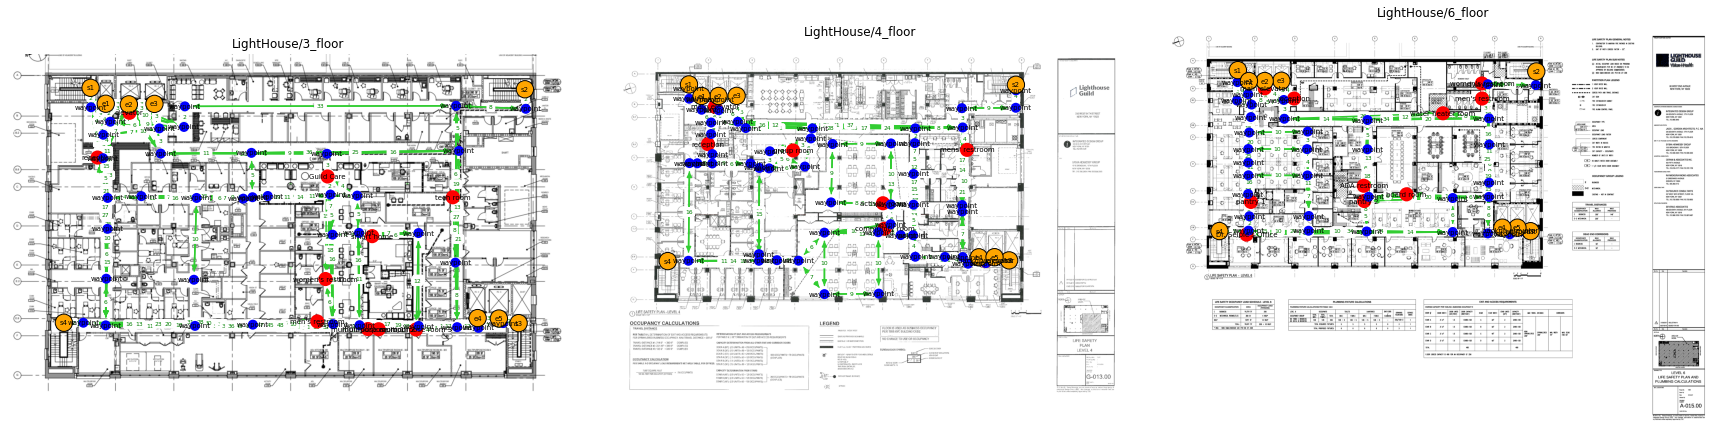

In [2]:
# === 1. Load Floorplan Data into FacilityNavigator ===
DATA_FINAL_ROOT = "/mnt/data/UNav-IO/data"
        
PLACES = ["New_York_City"]
BUILDINGS = ["LightHouse"]
FLOORS = ["3_floor", "4_floor", "6_floor"]

# Construct file paths for each floor
config = UNavConfig(
    data_final_root=DATA_FINAL_ROOT,
    places=PLACES,
    buildings=BUILDINGS,
    floors=FLOORS
)

# Initialize navigator with all floors
nav = FacilityNavigator(config.navigator_config)

draw_graph_on_floorplans(
    nav.G,
    pf_map=nav.pf_map,
    data_root=DATA_FINAL_ROOT,
    place="New_York_City",
    floor_keys=["LightHouse__3_floor", "LightHouse__4_floor", "LightHouse__6_floor"],
    show_virt=False
)


In [3]:
# === 2. Select Destination from a Target Floor ===
target_building = "LightHouse"
target_floor = "3_floor"
target_key = f"{target_building}__{target_floor}"

pf_target = nav.pf_map[target_key]

# List all destination points on that floor
destinations = [
    (pf_target.nodes[did], pf_target.labels[did])
    for did in pf_target.dest_ids
]

# Print destination options
print(f"Available Destinations in {target_building} - {target_floor}:")
for i, (pt, name) in enumerate(destinations):
    print(f"[{i}] {name}")

Available Destinations in LightHouse - 3_floor:
[0] elevator
[1] reception
[2] Guild Care
[3] women's restroom
[4] men's restroom
[5] multipurpose room 1
[6] multipurpose room 2
[7] multipurpose room 3
[8] smart home
[9] tech room


In [4]:
# === 3. Choose a Destination ===
selected_index = 5  # Index from the list printed above
selected_pt, selected_name = destinations[selected_index]
print(f"Selected destination: {selected_name} on {target_floor} of {target_building}")

Selected destination: multipurpose room 1 on 3_floor of LightHouse


In [5]:
# === 4. Sample a Random Starting Pose Across All Floors ===
key, (x, y), theta = sample_random_pose(nav.pf_map)
# === 4. Sample a Random Starting Pose Slightly Outside of Walkable Region Across All Floors ===
# key, (x, y), theta = perturb_pose_off_walkable_pose(nav.pf_map)

pf = nav.pf_map[key]
scale = nav.scales[key]
building, floor = key.split("__", 1)

print(f"Random current pose on {floor} of {building}: ({x:.2f}, {y:.2f}, θ={math.degrees(theta):.1f}°)")

Random current pose on 4_floor of LightHouse: (2333.58, 452.08, θ=68.1°)


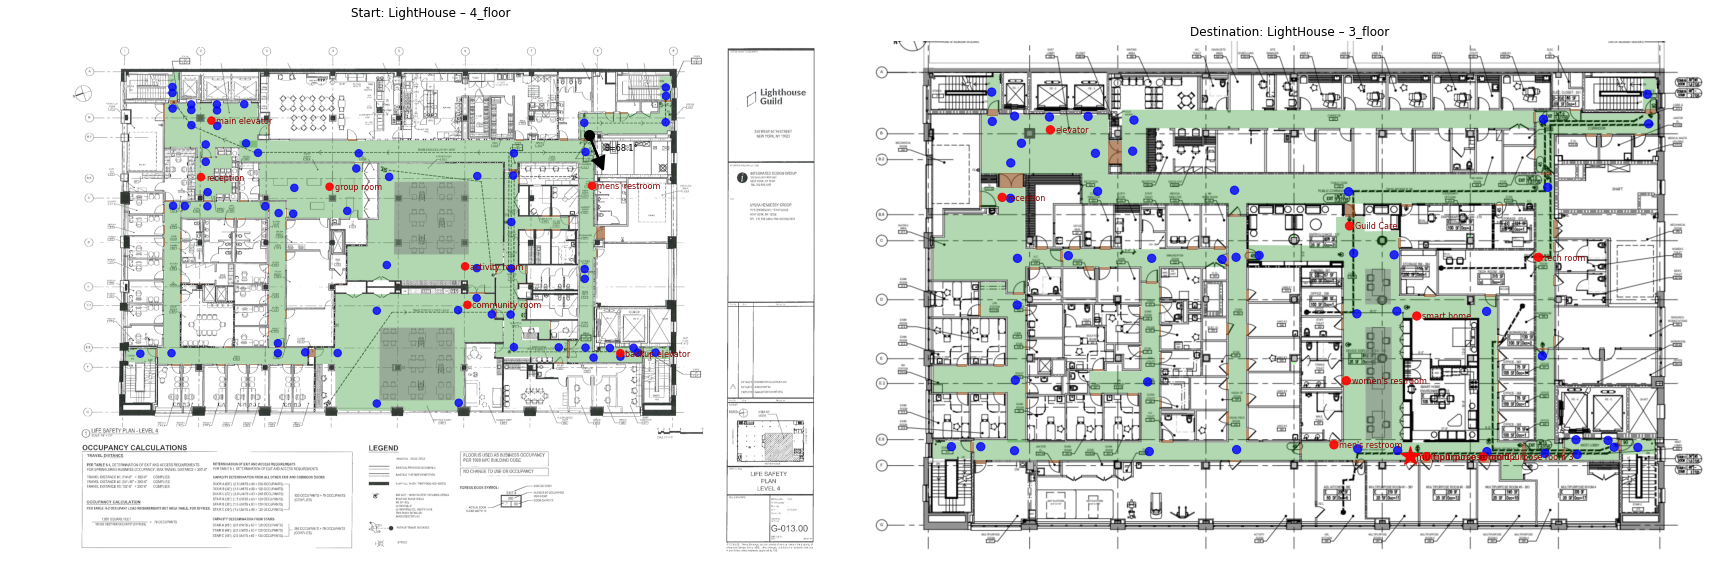

In [6]:
# === 5. Visualize Start & Destination Floors (single or side-by-side) ===

# Compute keys
start_key = key                      # e.g. "LightHouse__4_floor"
dest_key  = f"{target_building}__{target_floor}"
start_bld, start_flr = start_key.split("__",1)

# Helper to extract all layers from a PathFinder
def get_floor_data(pf):
    walkable  = pf.walkable_polygons
    obstacle  = pf.obstacle_polygons
    doors     = [poly for poly,_ in pf.door_polygons]
    wps       = [(pf.nodes[n], pf.labels[n]) for n in pf.nav_ids]
    inter_wps = [
        (pf.nodes[n], pf.labels[n], "")
        for n in pf.nav_ids
        if 'stair' in pf.labels[n].lower() or 'elevator' in pf.labels[n].lower()
    ]
    dests     = [(pf.nodes[n], pf.labels[n]) for n in pf.dest_ids]
    return walkable, obstacle, doors, wps, inter_wps, dests

# Load backgrounds
bg_start = mpimg.imread(os.path.join(DATA_FINAL_ROOT, PLACES[0], start_bld, start_flr, "floorplan.png"))
bg_dest  = mpimg.imread(os.path.join(DATA_FINAL_ROOT, PLACES[0], target_building, target_floor, "floorplan.png"))

pf_start = nav.pf_map[start_key]
pf_dest  = nav.pf_map[dest_key]

start_data = get_floor_data(pf_start)
dest_data  = get_floor_data(pf_dest)

# Create figure: 1 panel if same floor, else 2 panels
if start_key == dest_key:
    fig, ax = plt.subplots(1,1, figsize=(16,14))
    axes = [ax]
else:
    fig, (ax0, ax1) = plt.subplots(1,2, figsize=(24,14))
    axes = [ax0, ax1]

# --- Plot start floor ---
ax = axes[0]
ax.imshow( bg_start,
           extent=[0,bg_start.shape[1], bg_start.shape[0],0] )
plot_floorplan(ax, *start_data[:3])

# If same-floor: highlight destination here
if start_key == dest_key:
    plot_points(
        ax,
        start_data[3],            # waypoints
        start_data[4],            # inter-waypoints
        start_data[5],            # all destinations
        selected_dest=(selected_pt, selected_name)
    )
else:
    # multi-panel: draw all nav points on start side
    plot_points(ax, start_data[3], start_data[4], start_data[5])

plot_pose(ax, x, y, theta)
ax.set_title(f"Start: {start_bld} – {start_flr}")
ax.axis("off")

# --- Plot dest floor if different ---
if start_key != dest_key:
    ax = axes[1]
    ax.imshow( bg_dest,
               extent=[0,bg_dest.shape[1], bg_dest.shape[0],0] )
    plot_floorplan(ax, *dest_data[:3])
    # highlight only chosen destination
    plot_points(
        ax,
        dest_data[3],
        dest_data[4],
        dest_data[5],
        selected_dest=(selected_pt, selected_name)
    )
    ax.set_title(f"Destination: {target_building} – {target_floor}")
    ax.axis("off")

plt.tight_layout()
plt.show()


📋 Navigation commands:
1. You are currently in corridor 5 of LightHouse__4_floor.
2. Make a U-turn (6 o'clock)
3. Forward 5 feet
4. Sharp left to 7 o'clock
5. Go through a door in 53 feet
6. Forward 79 feet
7. Turn left to 11 o'clock
8. Forward 5 feet
9. Sharp left to 9 o'clock
10. Forward 7 feet
11. Approach the elevator and press down button to 3_floor of LightHouse.
12. You have arrived at 3_floor of LightHouse.
13. Proceed 12 o'clock
14. Forward 4 feet
15. Sharp right to 3 o'clock
16. Go through a door in 14 feet
17. Forward 44 feet
18. multipurpose room 1 on 9 o'clock

⏱️ Planning took 0.021 s
[INFO] Floor 4_floor segment length: 28.99 m


[INFO] Floor 3_floor segment length: 14.51 m


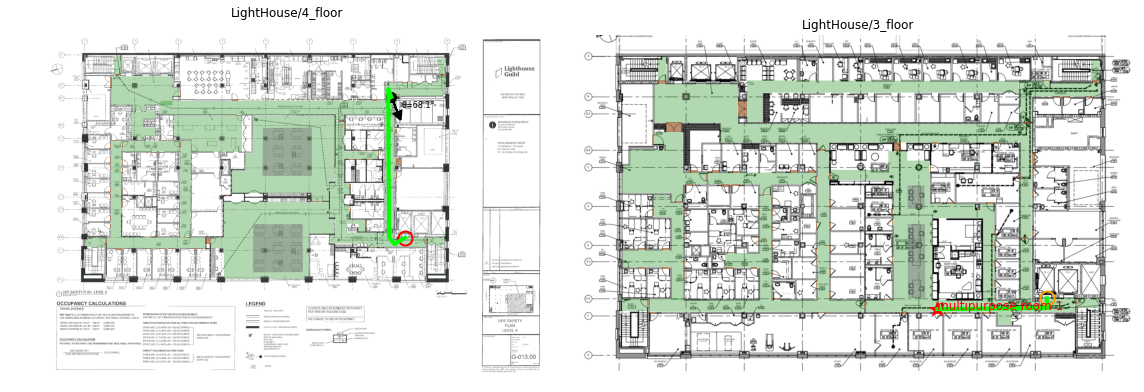

In [7]:
# === 6. PLAN & VISUALIZE A MULTI-FLOOR PATH (with error handling) ===

# 6.1 Look up dest_id
dest_id = pf_target.dest_ids[selected_index]

# 6.2 Compute shortest path
start_building, start_floor = building, floor
dest_building,  dest_floor  = target_building, target_floor
start_xy = (x, y)

t0 = time.time()
result = nav.find_path(
    start_building, start_floor, start_xy,
    dest_building,  dest_floor,  dest_id
)
t1 = time.time()

# 6.3 If no path, report and skip commands
if 'error' in result:
    print("❌ Navigation failed:", result['error'])
else:
    # 6.4 Generate commands
    cmds = commands_from_result(
        nav,
        result,
        initial_heading=-math.degrees(theta),
        unit="feet"
    )

    # 6.5 Print instructions and timing
    print("📋 Navigation commands:")
    for i, c in enumerate(cmds, 1):
        print(f"{i}. {c}")
    print(f"\n⏱️ Planning took {t1-t0:.3f} s")

plot_navigation_path(
    nav=nav,
    result=result,
    start_pose=(x, y, theta),
    data_root=DATA_FINAL_ROOT,
    start_building=start_building,
    start_floor=start_floor,
    dest_building=dest_building,
    dest_floor=dest_floor,
    selected_pt=selected_pt,
    selected_name=selected_name,
    place=PLACES[0]
)

